<a href="https://colab.research.google.com/github/nooralotibi/classifier/blob/main/Another_copy_of_Untitled7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Class Names: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


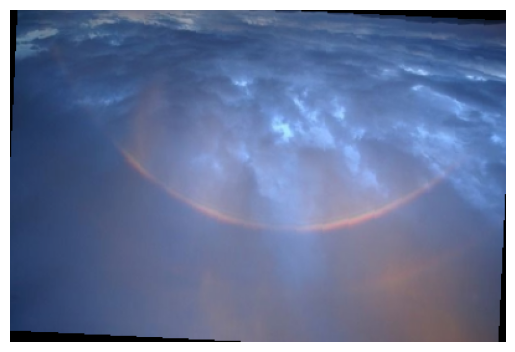

Validation Loss: 2.5501 | Validation Accuracy: 0.1160


In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split


transform = transforms.Compose([
    transforms.Resize((268, 400)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop((268, 400)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset_root = "/content/drive/MyDrive/dataset (1)"
dataset = datasets.ImageFolder(root=dataset_root, transform=transform)
class_names = dataset.classes
print("Class Names:", class_names)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

sample_images, _ = next(iter(train_loader))
image_array = sample_images[0].numpy()
image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min())
image_array = image_array.transpose(1, 2, 0)

plt.imshow(image_array)
plt.axis('off')
plt.show()


class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1_input_size = self.calculate_fc1_input_size()
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 11)

    def calculate_fc1_input_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 268, 400)
            x = self.conv1(x)
            x = F.relu(x)
            x = self.pool(x)
            x = self.conv2(x)
            x = F.relu(x)
            x = self.pool(x)
            x = self.conv3(x)
            x = F.relu(x)
            x = self.pool(x)
            return x.flatten().shape[0]

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x




model = CNNClassifier()
epochs = 5


def validate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in data_loader:
            output = model(images)
            loss = criterion(output, labels)
            _, predicted = torch.max(output, 1)
            total_loss += loss.item()
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples

    return average_loss, accuracy


def train(model, data_loader, criterion, optimizer, epochs=5, print_every=40):
    running_loss = 0
    steps = 0
    validation_interval = 2

    for e in range(epochs):
        model.train()

        for batch_idx, (images, labels) in enumerate(data_loader):
            steps += 1
            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if steps % print_every == 0:
                average_loss = running_loss / print_every
                print(f"Epoch: {e+1}/{epochs} | Step: {steps}/{len(data_loader)} | Loss: {average_loss:.4f}")
                running_loss = 0

            if steps % validation_interval == 0:
                val_loss, val_accuracy = validate(model, test_loader, criterion)
                print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

    return model


if any(param.requires_grad for param in model.parameters()):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    trained_model = train(model, train_loader, criterion, optimizer, epochs=epochs)
else:
    print("No train parameters.")

In [4]:
def predict(image):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((268, 400)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_label = class_names[predicted.item()]
    return predicted_label

In [5]:
from PIL import Image
image = Image.open('/content/drive/MyDrive/dataset (1)/dew/2208.jpg')
predicted_class = predict(image)
print("Predicted Class:", predicted_class)

Predicted Class: dew
